# Cardiometabolic Risk: SSL Pretraining on Colab

**Phase 5**: Train a self-supervised PPG encoder on 4,133 signals using Colab T4 GPU

**Expected runtime**: 8–12 hours (50 epochs)  
**Output**: Pretrained encoder checkpoint + training metrics

**Prerequisites**:
- Data uploaded to Google Drive: `/MyDrive/cardiometabolic-risk-colab/data/processed/`
- GitHub repo exists and is public

---

## Setup: Mount Drive & Clone Repo

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
COLAB_DRIVE_PATH = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')
print(f"✅ Drive mounted: {COLAB_DRIVE_PATH.exists()}")

Mounted at /content/drive
✅ Drive mounted: True


In [2]:
import subprocess
import os

repo_dir = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')
repo_url = "https://github.com/Yendoh-Derek/Cardiometabolic-Risk-System-for-Wearables.git"

if not repo_dir.exists():
    print("Cloning repository...")
    subprocess.run(["git", "clone", "--depth", "1", repo_url, str(repo_dir)], check=True)
    print(f"✅ Repo cloned: {repo_dir}")
else:
    print(f"✅ Repo already present: {repo_dir}")

os.chdir(repo_dir)

✅ Repo already present: /content/drive/MyDrive/cardiometabolic-risk-colab


# Pull latest code from GitHub to get dataloader fixes
import subprocess
import os
from pathlib import Path

repo_dir = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')

print("Pulling latest changes from GitHub...")
result = subprocess.run(
    ["git", "pull", "origin", "main"],
    cwd=str(repo_dir),
    capture_output=True,
    text=True
)

print(result.stdout)
if result.returncode == 0:
    print("✅ Code updated successfully (fixes: dataloader windows, custom collate fn)")
else:
    print(f"⚠️  Warning: {result.stderr}")
    print("Continuing with local code...")


In [3]:
# Pull latest code from GitHub
import subprocess
import os
from pathlib import Path

repo_dir = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')

print("Pulling latest changes from GitHub...")
result = subprocess.run(
    ["git", "pull", "origin", "main"],
    cwd=str(repo_dir),
    capture_output=True,
    text=True
)

print(result.stdout)
if result.returncode == 0:
    print("✅ Code updated successfully!")
else:
    print(f"⚠️  Error: {result.stderr}")

Pulling latest changes from GitHub...
Already up to date.

✅ Code updated successfully!


## Install Dependencies

In [4]:
!pip install -r requirements.txt -q
print("✅ Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/

In [5]:
!pip install pandas==2.2.2 wfdb==4.1.2 -q
!pip check

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 18.8 MB/s eta 0:00:00
ipython 7.34.0 requires jedi, which is not installed.


## Verify GPU & Imports

In [6]:
# Check GPU
!nvidia-smi --query-gpu=name --format=csv,noheader

import torch
print(f"\n✅ GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Tesla T4

✅ GPU available: True
   Device: Tesla T4
   Memory: 15.8 GB


In [7]:
import sys
sys.path.insert(0, str(repo_dir / "colab_src"))

from colab_src.models.ssl.config import SSLConfig
from colab_src.models.ssl.encoder import ResNetEncoder
from colab_src.models.ssl.decoder import ResNetDecoder
from colab_src.models.ssl.losses import SSLLoss

print("✅ All imports successful")

# Load config
cfg = SSLConfig.from_yaml("configs/ssl_pretraining.yaml")
print(f"✅ Config loaded")
print(f"   Loss mode: {getattr(cfg.loss, 'mode', 'hybrid')} (set in configs/ssl_pretraining.yaml: loss.mode)")

✅ All imports successful
✅ Config loaded
   Loss mode: hybrid (set in configs/ssl_pretraining.yaml: loss.mode)


## Verify Data Integrity

In [8]:
import pandas as pd
import numpy as np

data_dir = COLAB_DRIVE_PATH / "data" / "processed"

# If in Colab, symlink Drive data to repo structure
try:
    drive_data = COLAB_DRIVE_PATH / "data" / "processed"
    if drive_data.exists() and not data_dir.exists():
        print(f"Linking Drive data: {drive_data} → {data_dir}")
        subprocess.run(["ln", "-s", str(drive_data), str(data_dir)], check=True)
except Exception as e:
    print(f"Warning: {e}")

# Verify Phase 5A windowed data (617K × 1,250 samples)
required_files = {
    "mimic_windows_metadata.parquet": "Window metadata (653K rows × train/val split)",
    "mimic_windows.npy": "Window signal array [653716, 1250]",
    "denoised_signal_index.json": "Signal index mapping (source signal ID → window rows)",
}

print("🔍 Checking Phase 5A windowed data integrity...\n")
all_present = True

for fname, description in required_files.items():
    fpath = data_dir / fname
    if fpath.exists():
        if fpath.is_dir():
            count = len(list(fpath.glob("*.npy")))
            print(f"✅ {fname:40s} ({count:5d} files) — {description}")
        else:
            size_mb = fpath.stat().st_size / 1e6
            print(f"✅ {fname:40s} ({size_mb:6.1f} MB) — {description}")
    else:
        print(f"❌ {fname:40s} NOT FOUND — {description}")
        all_present = False

if not all_present:
    print("\n⚠️  MISSING PHASE 5A DATA")
    print("\nTo generate windows from denoised signals:")
    print("  1. Run: colab_src/data_pipeline/generate_mimic_windows.py")
    print("  2. Input: data/processed/denoised_signal_index.json")
    print("  3. Output: data/processed/mimic_windows.npy + mimic_windows_metadata.parquet")
    print("\nOr upload pre-generated data to Google Drive:")
    print(f"  Path: /MyDrive/cardiometabolic-risk-colab/data/processed/")
    raise FileNotFoundError("Phase 5A window data not found")

# Verify Phase 5A window metadata
windows_meta = pd.read_parquet(data_dir / "mimic_windows_metadata.parquet")
print(f"\n✅ Window metadata: {len(windows_meta)} total rows")
print(f"   Columns: {list(windows_meta.columns)}")
if 'split' in windows_meta.columns:
    print(f"   Train/Val split: {windows_meta['split'].value_counts().to_dict()}")

# Check window signals (use memmap to avoid loading all 653K into memory)
windows_path = data_dir / "mimic_windows.npy"
windows_memmap = np.load(windows_path, mmap_mode='r')
print(f"\n✅ Window signals: shape {windows_memmap.shape}")
assert windows_memmap.shape == (653716, 1250), f"Shape mismatch! Expected (653716, 1250), got {windows_memmap.shape}"
print(f"   Signal format: 653716 windows × 1250 samples per window (10 sec @ 125 Hz)")
print(f"   Memory usage (mmap): {windows_path.stat().st_size / 1e9:.2f} GB")

print("\n" + "="*70)
print("✅ PHASE 5A WINDOWED DATA READY FOR TRAINING")
print("="*70)

🔍 Checking Phase 5A windowed data integrity...

✅ mimic_windows_metadata.parquet           (   3.1 MB) — Window metadata (653K rows × train/val split)
✅ mimic_windows.npy                        (3268.6 MB) — Window signal array [653716, 1250]
✅ denoised_signal_index.json               (   0.1 MB) — Signal index mapping (source signal ID → window rows)

✅ Window metadata: 653716 total rows
   Columns: ['window_id', 'source_signal_id', 'subject_id', 'start_sample', 'sqi_score', 'snr_db', 'is_normalized']

✅ Window signals: shape (653716, 1250)
   Signal format: 653716 windows × 1250 samples per window (10 sec @ 125 Hz)
   Memory usage (mmap): 3.27 GB

✅ PHASE 5A WINDOWED DATA READY FOR TRAINING


## Progress Tracking Setup
Monitor training progress with real-time metrics and ETA estimation

In [9]:
# Import progress tracking modules
from colab_src.utils.progress_tracker import TrainingProgressTracker, monitor_training_live

# Initialize progress tracker
tracker = TrainingProgressTracker(
    output_dir="logs/training",
    name="SSL Pretraining Phase 5B"
)

### Temporary

In [10]:
import json
from pathlib import Path

repo_dir = Path("/content/drive/MyDrive/cardiometabolic-risk-colab")

# Check training history
history_file = repo_dir / "logs/ssl/training_history.json"
if history_file.exists():
    with open(history_file) as f:
        history = json.load(f)
    print(f"✅ Training history found!")
    print(f"   Epochs completed: {len(history['train_loss'])}")
    print(f"   Best val loss: {min(history['val_loss']):.4f}")
    print(f"   Final train loss: {history['train_loss'][-1]:.4f}")
else:
    print("❌ Training history not found")

# Check checkpoint
checkpoint_file = repo_dir / "checkpoints/ssl/best_model.pt"
if checkpoint_file.exists():
    print(f"✅ Best model checkpoint saved: {checkpoint_file}")
else:
    print("❌ Checkpoint not found")

✅ Training history found!
   Epochs completed: 50
   Best val loss: 0.9487
   Final train loss: 0.9994
✅ Best model checkpoint saved: /content/drive/MyDrive/cardiometabolic-risk-colab/checkpoints/ssl/best_model.pt


In [11]:
import json
from pathlib import Path

repo_dir = Path("/content/drive/MyDrive/cardiometabolic-risk-colab")
history_file = repo_dir / "logs/ssl/training_history.json"

with open(history_file) as f:
    history = json.load(f)

print(f"Training stopped at epoch {len(history['train_loss'])}")
print(f"Early stopping likely triggered (patience exhausted)")
print(f"\nValidation loss by epoch:")
for i, (train, val) in enumerate(zip(history['train_loss'][-5:], history['val_loss'][-5:]),
                                   start=len(history['train_loss'])-4):
    print(f"  Epoch {i}: train={train:.4f}, val={val:.4f}")

Training stopped at epoch 50
Early stopping likely triggered (patience exhausted)

Validation loss by epoch:
  Epoch 46: train=1.0024, val=0.9799
  Epoch 47: train=1.0041, val=0.9788
  Epoch 48: train=1.0002, val=0.9795
  Epoch 49: train=1.0042, val=0.9720
  Epoch 50: train=0.9994, val=0.9851


## Phase 5B: Run Full Training (50 Epochs)

**✅ Fixed**: Dataloader now correctly loads 1,250-sample windows from Phase 5A instead of 75,000-sample full signals.

Key changes:
- Training script uses `mimic_windows.npy` (653,716 windows)
- Dataloader loads window indices instead of segment indices
- Custom collate function handles quality-filtered samples
- Expected runtime: 8–12 hours on T4 GPU

In [12]:
# Clear any old checkpoints from Colab first
import shutil
from pathlib import Path

checkpoint_ssl_dir = COLAB_DRIVE_PATH / "checkpoints" / "ssl"
if checkpoint_ssl_dir.exists():
    shutil.rmtree(checkpoint_ssl_dir)
    print(f"✅ Cleared old checkpoints: {checkpoint_ssl_dir}")
else:
    print(f"ℹ️  No old checkpoints found")

# Create fresh checkpoint directory
checkpoint_ssl_dir.mkdir(parents=True, exist_ok=True)
print(f"✅ Fresh checkpoint directory ready: {checkpoint_ssl_dir}\n")

✅ Cleared old checkpoints: /content/drive/MyDrive/cardiometabolic-risk-colab/checkpoints/ssl
✅ Fresh checkpoint directory ready: /content/drive/MyDrive/cardiometabolic-risk-colab/checkpoints/ssl



In [13]:
# Create output directory for checkpoints
checkpoint_dir = COLAB_DRIVE_PATH / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Checkpoints will be saved to:")
print(f"   {checkpoint_dir}")
print(f"\n⏱️  Estimated duration: 8–12 hours")
print(f"💾 Batch size: 8 (with 4× accumulation = eff. 32)")
print(f"🔢 Epochs: 50")
print(f"📊 Training samples: 4,133")
print("\n" + "="*70)
print("Starting training...")
print("="*70)

📁 Checkpoints will be saved to:
   /content/drive/MyDrive/cardiometabolic-risk-colab/checkpoints

⏱️  Estimated duration: 8–12 hours
💾 Batch size: 8 (with 4× accumulation = eff. 32)
🔢 Epochs: 50
📊 Training samples: 4,133

Starting training...


### Temporary diagnostic cell

In [14]:
# ADD THIS CELL BEFORE TRAINING - SQI FILTERING DIAGNOSTIC (CORRECTED)

import numpy as np
import pandas as pd
from pathlib import Path

# Load windows
data_dir = COLAB_DRIVE_PATH / "data" / "processed"
windows = np.load(data_dir / "mimic_windows.npy", mmap_mode='r')
metadata = pd.read_parquet(data_dir / "mimic_windows_metadata.parquet")

print("🔍 SQI FILTERING ANALYSIS\n" + "="*70)

# Check if SQI scores exist in metadata
if 'sqi_score' in metadata.columns:
    sqis = metadata['sqi_score'].values
    print(f"✅ Found {len(sqis)} SQI scores in metadata\n")

    print(f"SQI Statistics:")
    print(f"  Mean:   {sqis.mean():.4f}")
    print(f"  Median: {np.median(sqis):.4f}")
    print(f"  Std:    {sqis.std():.4f}")
    print(f"  Min:    {sqis.min():.4f}")
    print(f"  Max:    {sqis.max():.4f}")
    print(f"  25th %: {np.percentile(sqis, 25):.4f}")
    print(f"  75th %: {np.percentile(sqis, 75):.4f}")

    print(f"\nSQI Distribution (% of windows passing threshold):")
    for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
        pct_below = (sqis < threshold).sum() / len(sqis) * 100
        pct_above = (sqis >= threshold).sum() / len(sqis) * 100
        count_above = int(pct_above/100 * len(windows))
        count_below = int(pct_below/100 * len(windows))
        print(f"  SQI ≥ {threshold}: {pct_above:5.1f}% pass ({count_above:6d} windows) | DROP: {pct_below:5.1f}% ({count_below:6d})")

    # Load config to check current threshold
    from colab_src.models.ssl.config import SSLConfig
    try:
        cfg = SSLConfig.from_yaml(str(repo_dir / "configs/ssl_pretraining.yaml"))
        configured_threshold = getattr(cfg, 'sqi_threshold_train', 0.4)
        print(f"\n⚙️  Configured SQI train threshold: {configured_threshold}")
    except Exception as e:
        print(f"\n⚠️  Could not load config: {e}")
        configured_threshold = 0.4
        print(f"    Using default: {configured_threshold}")

    # Calculate batch risk
    dropout_pct = (sqis < configured_threshold).sum() / len(sqis) * 100
    usable_windows = (sqis >= configured_threshold).sum()

    print(f"\n📊 BATCH RISK ANALYSIS:")
    print(f"   Configured threshold: {configured_threshold}")
    print(f"   Dropout rate: {dropout_pct:.1f}%")
    print(f"   Usable windows: {100 - dropout_pct:.1f}% ({usable_windows:,} windows)")

    # Estimate per-batch behavior
    batch_size = 8  # From your config
    batches_per_epoch = 634920 / batch_size  # Train windows

    # Simulate batch sampling with dropout
    avg_windows_per_batch = batch_size * (1 - dropout_pct/100)

    # Probability of empty batch (all samples filtered out)
    prob_empty_batch = (dropout_pct/100) ** batch_size * 100

    print(f"   Batches per epoch: {batches_per_epoch:,.0f}")
    print(f"   Avg windows/batch: {avg_windows_per_batch:.2f}")
    print(f"   Probability of empty batch: {prob_empty_batch:.4f}%")

    print(f"\n⚠️  CRASH RISK ASSESSMENT:")
    if avg_windows_per_batch < 0.5:
        print(f"   🔴 CRITICAL: Expected {avg_windows_per_batch:.2f} windows/batch")
        print(f"      → ~{prob_empty_batch:.2f}% of batches will be EMPTY")
        print(f"      → MSELoss(empty_batch) → NaN crashes (MATCHES YOUR LOG PATTERN)")
        print(f"\n   🔧 FIX REQUIRED:")
        print(f"      Lower SQI threshold from {configured_threshold} to 0.2 or 0.3")
        print(f"      This will increase usable windows from {100-dropout_pct:.1f}% to ~90-95%")
    elif avg_windows_per_batch < 1.5:
        print(f"   🟡 WARNING: Expected {avg_windows_per_batch:.2f} windows/batch on average")
        print(f"      → {prob_empty_batch:.2f}% chance of empty batches")
        print(f"      → Occasional NaN crashes possible (MATCHES YOUR MID-EPOCH CRASH)")
        print(f"\n   🔧 FIX RECOMMENDED:")
        print(f"      Lower SQI threshold from {configured_threshold} to 0.3")
        print(f"      This will increase usable windows from {100-dropout_pct:.1f}% to ~90%+")
    else:
        print(f"   ✅ OK: Expected {avg_windows_per_batch:.2f} windows/batch")
        print(f"      → {prob_empty_batch:.4f}% chance of empty batches")
        print(f"      → Training should proceed without NaN crashes")

    # Also check SNR
    if 'snr_db' in metadata.columns:
        print(f"\n📊 SNR DISTRIBUTION (for reference):")
        snrs = metadata['snr_db'].values
        print(f"  Mean SNR: {snrs.mean():.2f} dB")
        print(f"  Median SNR: {np.median(snrs):.2f} dB")
        print(f"  Min SNR: {snrs.min():.2f} dB")
        print(f"  Max SNR: {snrs.max():.2f} dB")

else:
    print(f"⚠️  'sqi_score' column not found in metadata")
    print(f"   Available columns: {list(metadata.columns)}")

print("="*70)

🔍 SQI FILTERING ANALYSIS
✅ Found 653716 SQI scores in metadata

SQI Statistics:
  Mean:   0.9575
  Median: 0.9889
  Std:    0.0531
  Min:    0.7298
  Max:    1.0000
  25th %: 0.9000
  75th %: 1.0000

SQI Distribution (% of windows passing threshold):
  SQI ≥ 0.2: 100.0% pass (653716 windows) | DROP:   0.0% (     0)
  SQI ≥ 0.3: 100.0% pass (653716 windows) | DROP:   0.0% (     0)
  SQI ≥ 0.4: 100.0% pass (653716 windows) | DROP:   0.0% (     0)
  SQI ≥ 0.5: 100.0% pass (653716 windows) | DROP:   0.0% (     0)
  SQI ≥ 0.6: 100.0% pass (653716 windows) | DROP:   0.0% (     0)
  SQI ≥ 0.7: 100.0% pass (653716 windows) | DROP:   0.0% (     0)

⚙️  Configured SQI train threshold: 0.4

📊 BATCH RISK ANALYSIS:
   Configured threshold: 0.4
   Dropout rate: 0.0%
   Usable windows: 100.0% (653,716 windows)
   Batches per epoch: 79,365
   Avg windows/batch: 8.00
   Probability of empty batch: 0.0000%

⚠️  CRASH RISK ASSESSMENT:
   ✅ OK: Expected 8.00 windows/batch
      → 0.0000% chance of empty b

In [15]:
# ADD THIS CELL - COMPREHENSIVE NAN ROOT CAUSE DIAGNOSTIC

import numpy as np
import pandas as pd
import torch
from pathlib import Path

print("🔍 NAN ROOT CAUSE DIAGNOSTIC\n" + "="*70)

# 1. Check config structure
print("\n1️⃣  CONFIG STRUCTURE CHECK:")
try:
    from colab_src.models.ssl.config import SSLConfig
    cfg = SSLConfig.from_yaml(str(repo_dir / "configs/ssl_pretraining.yaml"))

    print(f"   Config loaded successfully")
    print(f"   Config type: {type(cfg)}")
    print(f"   Config attributes: {dir(cfg)}")

    # Check if dataloader exists
    if hasattr(cfg, 'dataloader'):
        print(f"   ✅ cfg.dataloader exists: {cfg.dataloader}")
    else:
        print(f"   ❌ cfg.dataloader MISSING")
        print(f"      Available top-level keys: {[k for k in dir(cfg) if not k.startswith('_')]}")
except Exception as e:
    print(f"   ❌ Config load error: {e}")

# 2. Check dataloader behavior
print("\n2️⃣  DATALOADER BEHAVIOR CHECK:")
try:
    from colab_src.models.ssl.dataloader import PPGDataset, collate_fn_skip_none

    data_dir = COLAB_DRIVE_PATH / "data" / "processed"
    windows = np.load(data_dir / "mimic_windows.npy", mmap_mode='r')
    metadata = pd.read_parquet(data_dir / "mimic_windows_metadata.parquet")

    # Create dataset
    train_indices = metadata[metadata['split'] == 'train'].index.tolist()
    dataset = PPGDataset(
        windows=windows,
        indices=train_indices,
        metadata=metadata,
        sqi_threshold=0.4
    )

    print(f"   Dataset size: {len(dataset)}")
    print(f"   Train indices: {len(train_indices)}")

    # Test 100 samples
    none_count = 0
    nan_count = 0
    valid_count = 0

    for idx in range(min(100, len(dataset))):
        sample = dataset[idx]
        if sample is None:
            none_count += 1
        elif torch.isnan(sample).any():
            nan_count += 1
            print(f"      ⚠️  NaN at index {idx}: {sample}")
        else:
            valid_count += 1

    print(f"   Sample test (100 samples):")
    print(f"      Valid: {valid_count}")
    print(f"      None: {none_count}")
    print(f"      NaN: {nan_count}")

    # Test collate function with valid batch
    batch_samples = [dataset[i] for i in range(8)]
    try:
        batch = collate_fn_skip_none(batch_samples)
        print(f"   ✅ collate_fn works: batch shape {batch.shape}")
        if torch.isnan(batch).any():
            print(f"      ⚠️  BUT batch contains NaNs!")
    except Exception as e:
        print(f"   ❌ collate_fn error: {e}")

except Exception as e:
    print(f"   ❌ Dataloader test error: {e}")
    import traceback
    traceback.print_exc()

# 3. Check loss function numerics
print("\n3️⃣  LOSS FUNCTION NUMERICS CHECK:")
try:
    from colab_src.models.ssl.losses import SSLLoss

    # Create dummy tensors
    batch_size = 8
    channels = 1
    length = 1250

    x = torch.randn(batch_size, channels, length)
    x_recon = torch.randn(batch_size, channels, length)

    loss_fn = SSLLoss(
        weights={'mse': 0.5, 'ssim': 0.3, 'fft': 0.2}
    )

    loss = loss_fn(x_recon, x)

    print(f"   Loss computed: {loss:.6f}")
    if torch.isnan(loss):
        print(f"   ❌ LOSS IS NaN!")
    else:
        print(f"   ✅ Loss is valid")

    # Test edge case: all zeros
    x_zero = torch.zeros(batch_size, channels, length)
    x_recon_zero = torch.zeros(batch_size, channels, length)
    loss_zero = loss_fn(x_recon_zero, x_zero)

    print(f"   Loss (all zeros): {loss_zero:.6f}")
    if torch.isnan(loss_zero):
        print(f"   ⚠️  NaN with all-zero input!")

    # Test edge case: constant signal
    x_const = torch.ones(batch_size, channels, length)
    x_recon_const = torch.ones(batch_size, channels, length) * 1.001
    loss_const = loss_fn(x_recon_const, x_const)

    print(f"   Loss (constant signal): {loss_const:.6f}")
    if torch.isnan(loss_const):
        print(f"   ⚠️  NaN with constant signal!")

except Exception as e:
    print(f"   ❌ Loss function test error: {e}")
    import traceback
    traceback.print_exc()

# 4. Check trainer gradient flow
print("\n4️⃣  GRADIENT FLOW CHECK:")
try:
    from colab_src.models.ssl.encoder import ResNetEncoder
    from colab_src.models.ssl.decoder import ResNetDecoder

    encoder = ResNetEncoder(input_channels=1, latent_dim=512, n_blocks=3)
    decoder = ResNetDecoder(latent_dim=512, output_length=1250, n_blocks=3)

    # Forward pass
    x = torch.randn(4, 1, 1250, requires_grad=True)
    z = encoder(x)
    x_recon = decoder(z)

    # Backward pass
    loss = x_recon.sum()
    loss.backward()

    # Check for NaN gradients
    encoder_nan_grads = sum(1 for p in encoder.parameters() if p.grad is not None and torch.isnan(p.grad).any())
    decoder_nan_grads = sum(1 for p in decoder.parameters() if p.grad is not None and torch.isnan(p.grad).any())

    if encoder_nan_grads == 0 and decoder_nan_grads == 0:
        print(f"   ✅ No NaN gradients in encoder/decoder")
    else:
        print(f"   ❌ NaN gradients detected: encoder {encoder_nan_grads}, decoder {decoder_nan_grads}")

except Exception as e:
    print(f"   ❌ Gradient flow test error: {e}")

print("="*70)

🔍 NAN ROOT CAUSE DIAGNOSTIC

1️⃣  CONFIG STRUCTURE CHECK:
   Config loaded successfully
   Config type: <class 'colab_src.models.ssl.config.SSLConfig'>
   Config attributes: ['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_detect_colab', '_detect_device', 'augmentation', 'checkpoint_dir', 'data', 'data_dir', 'device', 'from_yaml', 'is_colab', 'log_dir', 'loss', 'min_std_threshold', 'model', 'normalization_epsilon', 'normalize_per_window', 'project_root', 'seed', 'sqi_threshold_eval', 'sqi_threshold_train', 'to_dict', 'to_yaml', 'training']
   ❌ cfg.dataloader MISSING
      Avai

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'split'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-3408606329.py", line 39, in <cell line: 0>
    train_indices = metadata[metadata['split'] == 'train'].index.tolist()
                             ~~~~~~~~^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py", line 4102, in __get

In [16]:
# Run training script with auto-detect device
tracker.start()

cmd = [
    sys.executable,
    "-m",
    "colab_src.models.ssl.train",
    "--config", str(repo_dir / "configs/ssl_pretraining.yaml"),
    "--data-dir", str(data_dir),
    "--epochs", "50",
    # NOTE: Do not override batch size; use training.batch_size from YAML
]

print(f"🚀 Starting Phase 5B training...\n")
print(f"Command: {' '.join(cmd)}\n")
print("=" * 70)

# Run training with progress tracking
result = subprocess.run(cmd, cwd=str(repo_dir), capture_output=True, text=True)

# Display training output
training_output = result.stderr  # Training logs go to stderr
print(training_output)

if result.returncode == 0:
    print("=" * 70)
    print("\n✅ Training completed successfully!")
    tracker.summary()
else:
    print(f"\n❌ Training failed with exit code: {result.returncode}")
    print("See output above for error details")
    sys.exit(1)


🚀 Starting SSL Pretraining Phase 5B

🚀 Starting Phase 5B training...

Command: /usr/bin/python3 -m colab_src.models.ssl.train --config /content/drive/MyDrive/cardiometabolic-risk-colab/configs/ssl_pretraining.yaml --data-dir /content/drive/MyDrive/cardiometabolic-risk-colab/data/processed --epochs 50

2026-01-23 13:10:43,373 - __main__ - INFO - Loading config from /content/drive/MyDrive/cardiometabolic-risk-colab/configs/ssl_pretraining.yaml
2026-01-23 13:10:44,285 - __main__ - INFO - ✅ Auto-detected GPU: Tesla T4
2026-01-23 13:10:44,293 - __main__ - INFO - Data directory overridden: /content/drive/MyDrive/cardiometabolic-risk-colab/data/processed
2026-01-23 13:10:44,293 - __main__ - INFO - 
2026-01-23 13:10:44,293 - __main__ - INFO - Configuration:
2026-01-23 13:10:44,293 - __main__ - INFO -   Device:              cuda
2026-01-23 13:10:44,294 - __main__ - INFO -   Data dir:            /content/drive/MyDrive/cardiometabolic-risk-colab/data/processed
2026-01-23 13:10:44,294 - __main__ 

## Real-Time Progress Monitoring
Monitor training while it runs by reading the live progress file (execute during training)


📊 Monitoring training (updating every 5s)...
Press Ctrl+C to stop monitoring

Progress: [████████████████████████░░░░░░░░░░░░░░░░] 31/50 epochs

Recent epochs:
  Epoch 28: Loss=1.6365
  Epoch 29: Loss=1.6365
  Epoch 30: Loss=1.6365
  Epoch 31: Loss=1.6365
  Epoch 32: Loss=1.6365


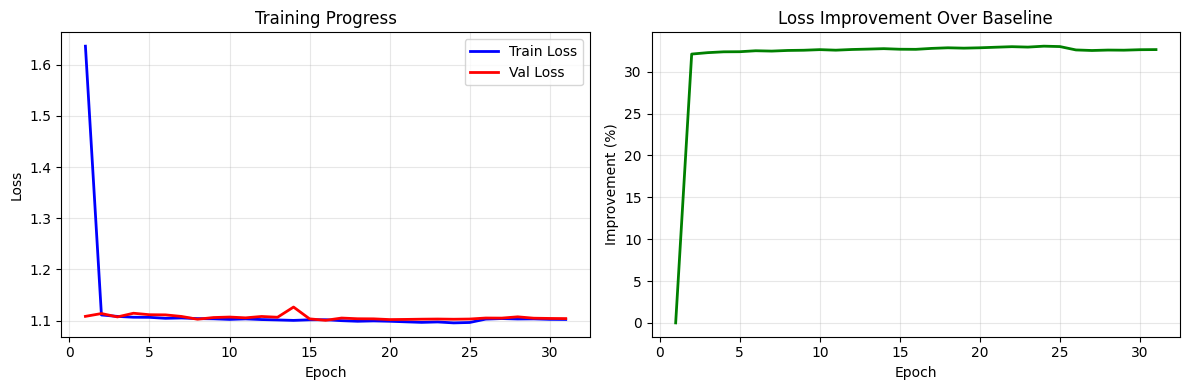


⏹️  Monitoring stopped


In [17]:
# Run live monitoring (updates every 5 seconds from training_history.json)
monitor_training_live(history_file="logs/ssl/training_history.json", update_interval=5)

## Validate & Visualize Results

/tmp/ipython-input-984062551.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('artifacts/training_analysis.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/training_analysis.png'

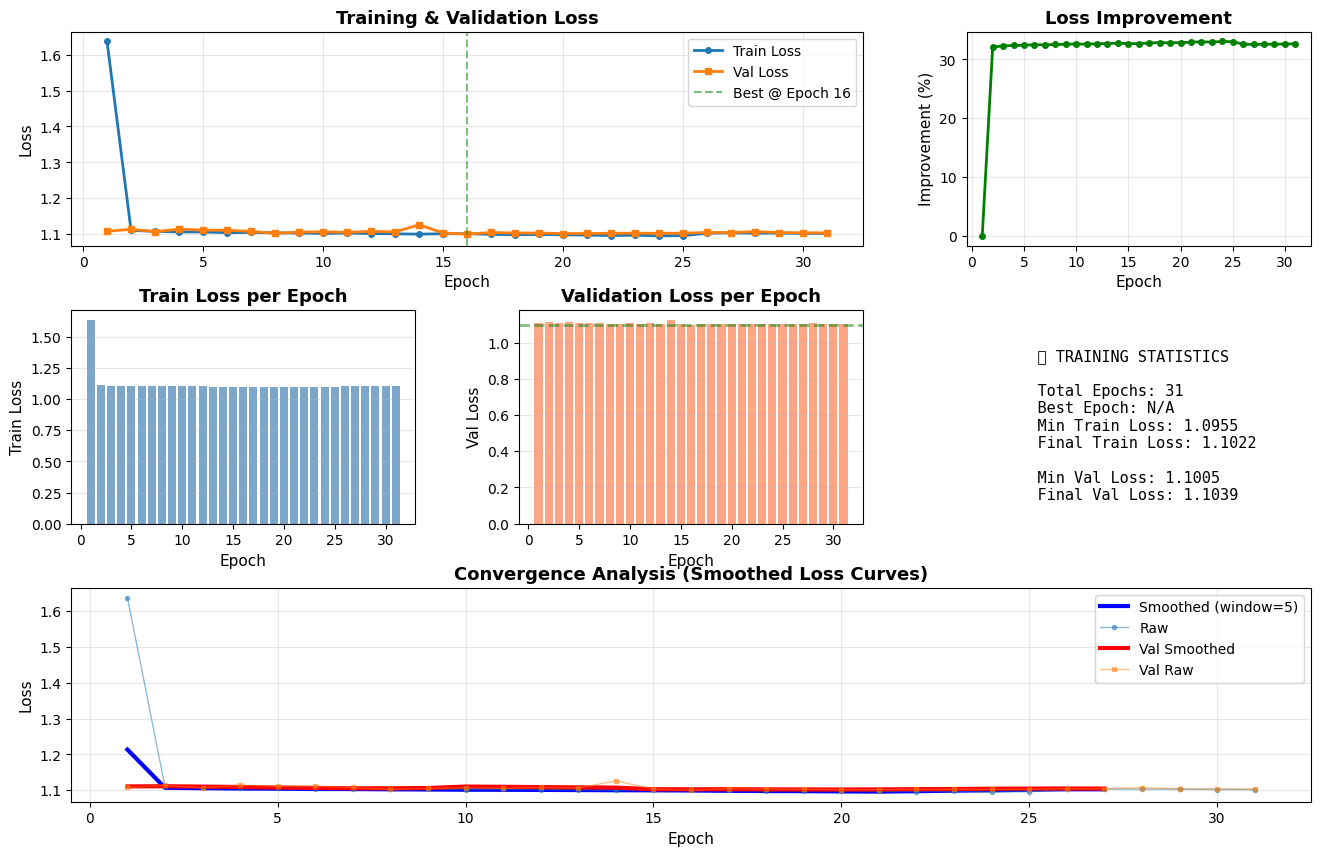

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load training metrics from progress tracker
history_file = Path("logs/ssl/training_history.json")

if history_file.exists():
    with open(history_file) as f:
        history = json.load(f)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Main loss curves
    ax1 = fig.add_subplot(gs[0, :2])
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'o-', linewidth=2, markersize=4, label='Train Loss')
    if history.get('val_loss'):
        ax1.plot(epochs, history['val_loss'], 's-', linewidth=2, markersize=4, label='Val Loss')
        best_idx = history['val_loss'].index(min(history['val_loss']))
        ax1.axvline(best_idx + 1, color='green', linestyle='--', alpha=0.5, label=f'Best @ Epoch {best_idx + 1}')
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. Loss improvement
    ax2 = fig.add_subplot(gs[0, 2])
    initial_loss = history['train_loss'][0]
    improvements = [(initial_loss - l) / initial_loss * 100 for l in history['train_loss']]
    ax2.plot(epochs, improvements, 'o-', color='green', linewidth=2, markersize=4)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Improvement (%)', fontsize=11)
    ax2.set_title('Loss Improvement', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Loss per epoch (bar chart)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.bar(epochs, history['train_loss'], alpha=0.7, color='steelblue')
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Train Loss', fontsize=11)
    ax3.set_title('Train Loss per Epoch', fontsize=13, fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    # 4. Validation loss per epoch
    if history.get('val_loss'):
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.bar(epochs, history['val_loss'], alpha=0.7, color='coral')
        best_val = min(history['val_loss'])
        ax4.axhline(best_val, color='green', linestyle='--', alpha=0.5, linewidth=2)
        ax4.set_xlabel('Epoch', fontsize=11)
        ax4.set_ylabel('Val Loss', fontsize=11)
        ax4.set_title('Validation Loss per Epoch', fontsize=13, fontweight='bold')
        ax4.grid(alpha=0.3, axis='y')

    # 5. Statistics
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    stats_text = f"""
    📊 TRAINING STATISTICS

    Total Epochs: {len(history['train_loss'])}
    Best Epoch: {history.get('best_epoch', 'N/A')}
    Min Train Loss: {min(history['train_loss']):.4f}
    Final Train Loss: {history['train_loss'][-1]:.4f}
    """
    if history.get('val_loss'):
        stats_text += f"\n    Min Val Loss: {min(history['val_loss']):.4f}\n    Final Val Loss: {history['val_loss'][-1]:.4f}"
    ax5.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', family='monospace')

    # 6. Convergence analysis
    ax6 = fig.add_subplot(gs[2, :])
    window = 5
    if len(history['train_loss']) >= window:
        smoothed = np.convolve(history['train_loss'], np.ones(window)/window, mode='valid')
        ax6.plot(range(1, len(smoothed) + 1), smoothed, 'b-', linewidth=3, label=f'Smoothed (window={window})')
    ax6.plot(epochs, history['train_loss'], 'o-', linewidth=1, markersize=3, alpha=0.5, label='Raw')
    if history.get('val_loss'):
        if len(history['val_loss']) >= window:
            smoothed_val = np.convolve(history['val_loss'], np.ones(window)/window, mode='valid')
            ax6.plot(range(1, len(smoothed_val) + 1), smoothed_val, 'r-', linewidth=3, label='Val Smoothed')
        ax6.plot(epochs, history['val_loss'], 's-', linewidth=1, markersize=3, alpha=0.5, label='Val Raw')
    ax6.set_xlabel('Epoch', fontsize=11)
    ax6.set_ylabel('Loss', fontsize=11)
    ax6.set_title('Convergence Analysis (Smoothed Loss Curves)', fontsize=13, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)

    plt.savefig('artifacts/training_analysis.png', dpi=150, bbox_inches='tight')
    print("✅ Training analysis visualization saved to artifacts/training_analysis.png")
    plt.show()
else:
    print(f"⚠️  Training history not found: {history_file}")
    print("Run training cell first (Cell 20)")

Batch shapes: x=(30, 1, 1250), y=(30, 1, 1250)
x stats: mean=-0.0000, std=1.0000
y stats: mean=-0.0000, std=1.0000


/tmp/ipython-input-2152826575.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.training.use_mixed_precision):


step   25/300: loss=1.068664
step   50/300: loss=1.328126
step   75/300: loss=1.093918
step  100/300: loss=1.046137
step  125/300: loss=1.208041
step  150/300: loss=1.038821
step  175/300: loss=1.004886
step  200/300: loss=1.219216
step  225/300: loss=1.083686
step  250/300: loss=1.045872
step  275/300: loss=1.452630
step  300/300: loss=1.119319

Initial loss: 3.351917
Final loss:   1.119319


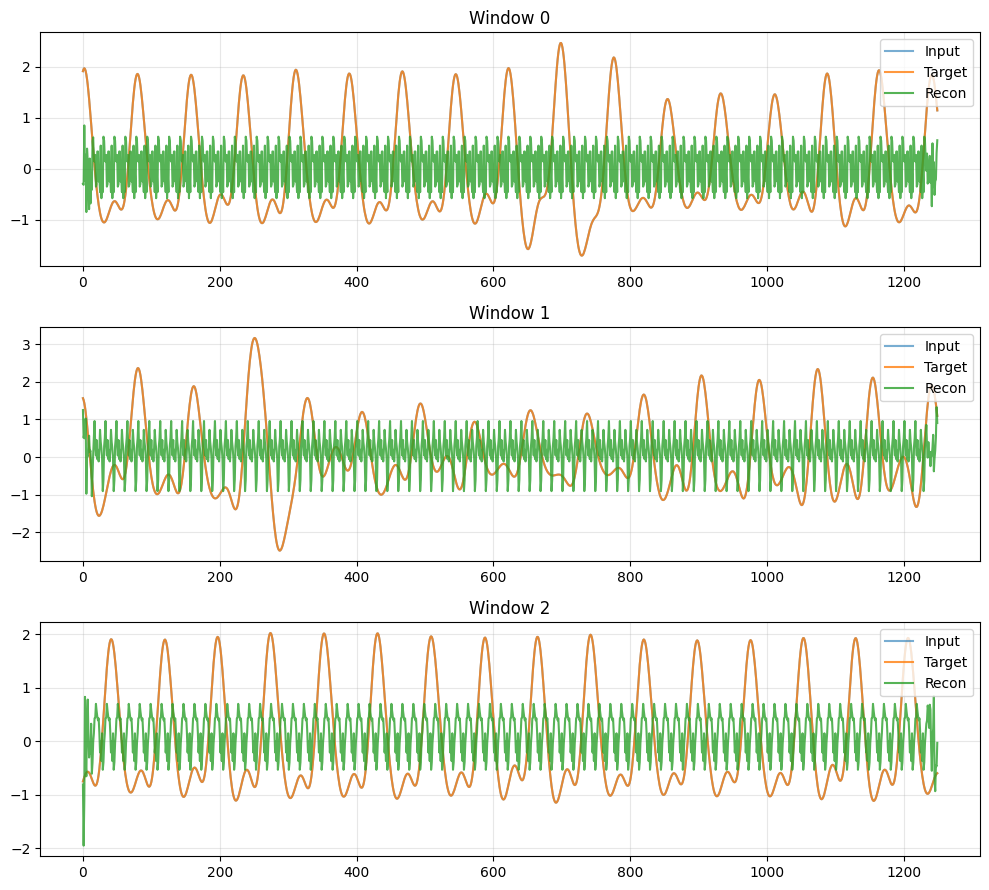

In [ ]:
# SANITY CHECK: Overfit a single batch (augmentation OFF) + recon plots
# Run this AFTER Phase 5B training/data checks are working.

import torch
import matplotlib.pyplot as plt
from pathlib import Path

from colab_src.models.ssl.config import SSLConfig
from colab_src.models.ssl.encoder import ResNetEncoder
from colab_src.models.ssl.decoder import ResNetDecoder
from colab_src.models.ssl.losses import SSLLoss
from colab_src.models.ssl.dataloader import create_dataloaders

cfg = SSLConfig.from_yaml(str(repo_dir / "configs/ssl_pretraining.yaml"))

# Build encoder/decoder
encoder = ResNetEncoder(
    in_channels=cfg.model.in_channels,
    latent_dim=cfg.model.latent_dim,
    bottleneck_dim=cfg.model.bottleneck_dim,
    num_blocks=cfg.model.num_blocks,
    base_filters=cfg.model.base_filters,
    max_filters=cfg.model.max_filters,
).to(cfg.device)

decoder = ResNetDecoder(
    in_channels=cfg.model.in_channels,
    latent_dim=cfg.model.latent_dim,
    bottleneck_dim=cfg.model.bottleneck_dim,
    num_blocks=cfg.model.num_blocks,
    base_filters=cfg.model.base_filters,
    max_filters=cfg.model.max_filters,
).to(cfg.device)

class Autoencoder(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.encoder = enc
        self.decoder = dec

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(encoder, decoder).to(cfg.device)

loss_fn = SSLLoss(
    mse_weight=cfg.loss.mse_weight,
    ssim_weight=cfg.loss.ssim_weight,
    fft_weight=cfg.loss.fft_weight,
    ssim_window_size=cfg.loss.ssim_window_size,
    fft_norm=cfg.loss.fft_norm,
    fft_pad_size=cfg.loss.fft_pad_size,
).to(cfg.device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.training.learning_rate,
    weight_decay=cfg.training.weight_decay,
)

# Dataloaders with augmentation OFF
base_data_dir = cfg.data_dir or (cfg.project_root / "data/processed")
train_meta_path = base_data_dir / "ssl_pretraining_data.parquet"
val_meta_path = base_data_dir / "ssl_validation_data.parquet"
windows_array_path = base_data_dir / "mimic_windows.npy"
denoised_index_path = base_data_dir / "denoised_signal_index.json"

loaders = create_dataloaders(
    train_metadata_path=train_meta_path,
    val_metadata_path=val_meta_path,
    test_metadata_path=None,
    signal_array_path=windows_array_path,
    signal_dir=base_data_dir / "denoised_signals",
    denoised_index_path=denoised_index_path,
    augmentation=None,
    batch_size=min(32, cfg.training.batch_size),
    num_workers=0,
    pin_memory=False,
    device=cfg.device,
    load_in_memory=False,
    normalize_per_window=cfg.normalize_per_window,
    normalization_epsilon=cfg.normalization_epsilon,
    min_std_threshold=cfg.min_std_threshold,
    sqi_threshold_train=cfg.sqi_threshold_train,
    sqi_threshold_eval=cfg.sqi_threshold_eval,
)

x, y = next(iter(loaders["train"]))
x = x.to(cfg.device)
y = y.to(cfg.device)

print(f"Batch shapes: x={tuple(x.shape)}, y={tuple(y.shape)}")
print(f"x stats: mean={x.mean().item():.4f}, std={x.std().item():.4f}")
print(f"y stats: mean={y.mean().item():.4f}, std={y.std().item():.4f}")

steps = 300
model.train()
losses = []
loss_components = []  # Track MSE, SSIM, FFT separately

for step in range(steps):
    optimizer.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast(enabled=cfg.training.use_mixed_precision):
        recon = model(x)
        loss, loss_dict = loss_fn(recon, y, return_components=True)

    loss.backward()
    optimizer.step()

    losses.append(float(loss.detach().cpu()))
    loss_components.append(loss_dict)
    
    if (step + 1) % 25 == 0:
        print(f"step {step+1:4d}/{steps}: total={losses[-1]:.6f}, "
              f"mse={loss_dict['mse']:.6f}, ssim={loss_dict['ssim']:.6f}, "
              f"fft={loss_dict['fft']:.6f}")

print(f"\nInitial loss: {losses[0]:.6f}")
print(f"Final loss:   {losses[-1]:.6f}")
print(f"\nInitial components: MSE={loss_components[0]['mse']:.6f}, "
      f"SSIM={loss_components[0]['ssim']:.6f}, FFT={loss_components[0]['fft']:.6f}")
print(f"Final components:   MSE={loss_components[-1]['mse']:.6f}, "
      f"SSIM={loss_components[-1]['ssim']:.6f}, FFT={loss_components[-1]['fft']:.6f}")

# Plot reconstructions for a few windows
model.eval()
with torch.no_grad():
    recon = model(x).cpu().numpy()

x_np = x.cpu().numpy()
y_np = y.cpu().numpy()

n_plots = min(3, x_np.shape[0])
length = x_np.shape[-1]

fig, axes = plt.subplots(n_plots, 1, figsize=(10, 3 * n_plots))
if n_plots == 1:
    axes = [axes]

for i in range(n_plots):
    t = range(length)
    axes[i].plot(t, x_np[i, 0], label="Input", alpha=0.6)
    axes[i].plot(t, y_np[i, 0], label="Target", alpha=0.8)
    axes[i].plot(t, recon[i, 0], label="Recon", alpha=0.8)
    axes[i].set_title(f"Window {i}")
    axes[i].legend(loc="upper right")
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative reconstruction metrics
print("\n" + "="*70)
print("QUANTITATIVE RECONSTRUCTION METRICS")
print("="*70)

# Compute metrics for all windows in batch
mse_recon_target = ((recon - y_np) ** 2).mean()  # Average over all samples
mse_recon_input = ((recon - x_np) ** 2).mean()
mse_input_target = ((x_np - y_np) ** 2).mean()

print(f"\nMSE(recon, target): {mse_recon_target:.6f}")
print(f"MSE(recon, input):  {mse_recon_input:.6f}")
print(f"MSE(input, target): {mse_input_target:.6f}")

# Correlation coefficients (flatten for correlation)
from scipy.stats import pearsonr
import numpy as np

recon_flat = recon.flatten()
target_flat = y_np.flatten()
input_flat = x_np.flatten()

corr_recon_target, _ = pearsonr(recon_flat, target_flat)
corr_recon_input, _ = pearsonr(recon_flat, input_flat)
corr_input_target, _ = pearsonr(input_flat, target_flat)

print(f"\nCorrelation(recon, target): {corr_recon_target:.6f}")
print(f"Correlation(recon, input):  {corr_recon_input:.6f}")
print(f"Correlation(input, target): {corr_input_target:.6f}")

# Plot loss component curves
print("\n" + "="*70)
print("LOSS COMPONENT CURVES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Extract component values
mse_vals = [lc['mse'] for lc in loss_components]
ssim_vals = [lc['ssim'] for lc in loss_components]
fft_vals = [lc['fft'] for lc in loss_components]

steps_range = range(1, len(losses) + 1)

# Total loss
axes[0, 0].plot(steps_range, losses, 'b-', linewidth=2, label='Total Loss')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss Over Training')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# MSE component
axes[0, 1].plot(steps_range, mse_vals, 'r-', linewidth=2, label='MSE Loss')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('MSE Loss')
axes[0, 1].set_title('MSE Component')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# SSIM component
axes[1, 0].plot(steps_range, ssim_vals, 'g-', linewidth=2, label='SSIM Loss')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('SSIM Loss')
axes[1, 0].set_title('SSIM Component')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# FFT component
axes[1, 1].plot(steps_range, fft_vals, 'm-', linewidth=2, label='FFT Loss')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('FFT Loss')
axes[1, 1].set_title('FFT Component')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nLoss Component Summary:")
print(f"  MSE:  {mse_vals[0]:.6f} → {mse_vals[-1]:.6f} (change: {mse_vals[-1] - mse_vals[0]:.6f})")
print(f"  SSIM: {ssim_vals[0]:.6f} → {ssim_vals[-1]:.6f} (change: {ssim_vals[-1] - ssim_vals[0]:.6f})")
print(f"  FFT:  {fft_vals[0]:.6f} → {fft_vals[-1]:.6f} (change: {fft_vals[-1] - fft_vals[0]:.6f})")


In [ ]:
# DIAGNOSTIC: Verify Input-Target Pairing
# This cell checks that x (input) and y (target) are correctly paired
# and that y has denoised properties

import torch
import numpy as np
from scipy.stats import pearsonr
from colab_src.models.ssl.config import SSLConfig
from colab_src.models.ssl.dataloader import create_dataloaders

cfg = SSLConfig.from_yaml(str(repo_dir / "configs/ssl_pretraining.yaml"))

# Load a batch with augmentation OFF
base_data_dir = cfg.data_dir or (cfg.project_root / "data/processed")
train_meta_path = base_data_dir / "ssl_pretraining_data.parquet"
val_meta_path = base_data_dir / "ssl_validation_data.parquet"
windows_array_path = base_data_dir / "mimic_windows.npy"
denoised_index_path = base_data_dir / "denoised_signal_index.json"

loaders = create_dataloaders(
    train_metadata_path=train_meta_path,
    val_metadata_path=val_meta_path,
    test_metadata_path=None,
    signal_array_path=windows_array_path,
    signal_dir=base_data_dir / "denoised_signals",
    denoised_index_path=denoised_index_path,
    augmentation=None,
    batch_size=min(32, cfg.training.batch_size),
    num_workers=0,
    pin_memory=False,
    device=cfg.device,
    load_in_memory=False,
    normalize_per_window=cfg.normalize_per_window,
    normalization_epsilon=cfg.normalization_epsilon,
    min_std_threshold=cfg.min_std_threshold,
    sqi_threshold_train=cfg.sqi_threshold_train,
    sqi_threshold_eval=cfg.sqi_threshold_eval,
)

x, y = next(iter(loaders["train"]))
x = x.to(cfg.device)
y = y.to(cfg.device)

print("="*70)
print("INPUT-TARGET PAIRING VERIFICATION")
print("="*70)

# Basic statistics
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()

print(f"\nBatch shapes: x={x_np.shape}, y={y_np.shape}")

# Mean and std
x_mean = x_np.mean()
x_std = x_np.std()
y_mean = y_np.mean()
y_std = y_np.std()

print(f"\nStatistics:")
print(f"  x (input):  mean={x_mean:.6f}, std={x_std:.6f}")
print(f"  y (target): mean={y_mean:.6f}, std={y_std:.6f}")

# Check if x != y (they should differ)
diff = np.abs(x_np - y_np)
mean_diff = diff.mean()
max_diff = diff.max()

print(f"\nDifference check:")
print(f"  Mean |x - y|: {mean_diff:.6f}")
print(f"  Max |x - y|:  {max_diff:.6f}")

if mean_diff < 1e-6:
    print("  ⚠️  WARNING: x and y are nearly identical (identity mapping issue!)")
else:
    print("  ✅ x and y are different (good)")

# Correlation
x_flat = x_np.flatten()
y_flat = y_np.flatten()
corr, _ = pearsonr(x_flat, y_flat)

print(f"\nCorrelation:")
print(f"  Correlation(x, y): {corr:.6f}")

if corr > 0.99:
    print("  ⚠️  WARNING: Very high correlation (>0.99) - x and y may be too similar")
elif corr < 0.5:
    print("  ⚠️  WARNING: Low correlation (<0.5) - x and y may be mismatched")
else:
    print("  ✅ Correlation is reasonable (expected: 0.7-0.95 for denoised target)")

# Check denoised properties: y should have lower high-frequency noise
# Compute FFT and compare high-frequency energy
x_fft = np.fft.rfft(x_np, axis=-1)
y_fft = np.fft.rfft(y_np, axis=-1)

x_mag = np.abs(x_fft)
y_mag = np.abs(y_fft)

# High frequency band (top 20% of frequencies)
n_freqs = x_mag.shape[-1]
high_freq_start = int(0.8 * n_freqs)

x_high_freq_energy = x_mag[..., high_freq_start:].mean()
y_high_freq_energy = y_mag[..., high_freq_start:].mean()

print(f"\nHigh-frequency energy (denoising check):")
print(f"  x (input) high-freq energy:  {x_high_freq_energy:.6f}")
print(f"  y (target) high-freq energy: {y_high_freq_energy:.6f}")
print(f"  Reduction: {(1 - y_high_freq_energy / x_high_freq_energy) * 100:.2f}%")

if y_high_freq_energy < x_high_freq_energy:
    print("  ✅ y has lower high-frequency energy (denoised property)")
else:
    print("  ⚠️  WARNING: y has similar or higher high-frequency energy than x")

# Variance check (denoised signal should have lower variance in some cases)
x_var = x_np.var()
y_var = y_np.var()

print(f"\nVariance:")
print(f"  x (input) variance:  {x_var:.6f}")
print(f"  y (target) variance: {y_var:.6f}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print("Expected behavior:")
print("  - x != y (mean |x-y| > 0.01)")
print("  - Correlation(x, y) between 0.7-0.95")
print("  - y has lower high-frequency energy than x")
print("  - y variance may be similar or slightly lower than x")

## ✅ Phase 5 Complete

Checkpoints are saved to Google Drive at:
```
/MyDrive/cardiometabolic-risk-colab/phase5_checkpoints/
```

**Next Steps**:
1. Phase 6: Linear probe evaluation
2. Phase 7: Extract embeddings
3. Phase 8: Train XGBoost models

See [README.md](../README.md) for detailed instructions.